In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score
#module importin

# Loading data
# ==========================================
transform = transforms.Compose([transforms.ToTensor()])

# data loading
data_batch_1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
data_batch_2 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

X1 = data_batch_1.data
y1 = np.array(data_batch_1.targets)
X2 = data_batch_2.data
y2 = np.array(data_batch_2.targets)

#concatinate all data into one array
X_all = np.concatenate([X1, X2], axis=0)
y_all = np.concatenate([y1, y2], axis=0)

print(f"Merged Total Shape: X={X_all.shape}, y={y_all.shape}")



# Data splitting into train and test randomly
# ==========================================
print("\nSplitting data manually: 1000 random samples per class for Test, rest for Train...")

np.random.seed(42)#random seed for reproducibility

train_indices = []
test_indices = []

#allocate each instance in same label to batch
for class_id in range(10):
    indices = np.where(y_all == class_id)[0]

    np.random.shuffle(indices)#shuffle data

    test_indices.extend(indices[:1000])#extend test indices
    train_indices.extend(indices[1000:])#extend train indices

np.random.shuffle(train_indices)#shuffle data
np.random.shuffle(test_indices)#shuffle data

#save data
X_train = X_all[train_indices]
y_train = y_all[train_indices]

X_test = X_all[test_indices]
y_test = y_all[test_indices]

100.0%


Merged Total Shape: X=(60000, 32, 32, 3), y=(60000,)

Splitting data manually: 1000 random samples per class for Test, rest for Train...



[Part A-(a)] Training PCA...
Determined dimensions -> n: 32, d: 2
PCA Done. Train Shape: (50000, 2), Test Shape: (10000, 2)

[Part A-(b)] Plotting Scatter plots...


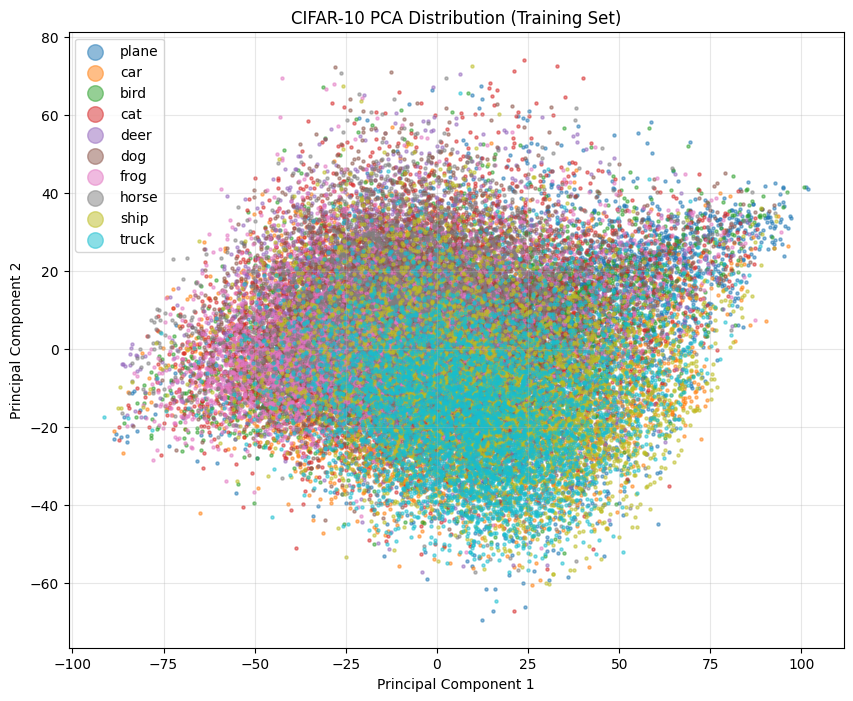

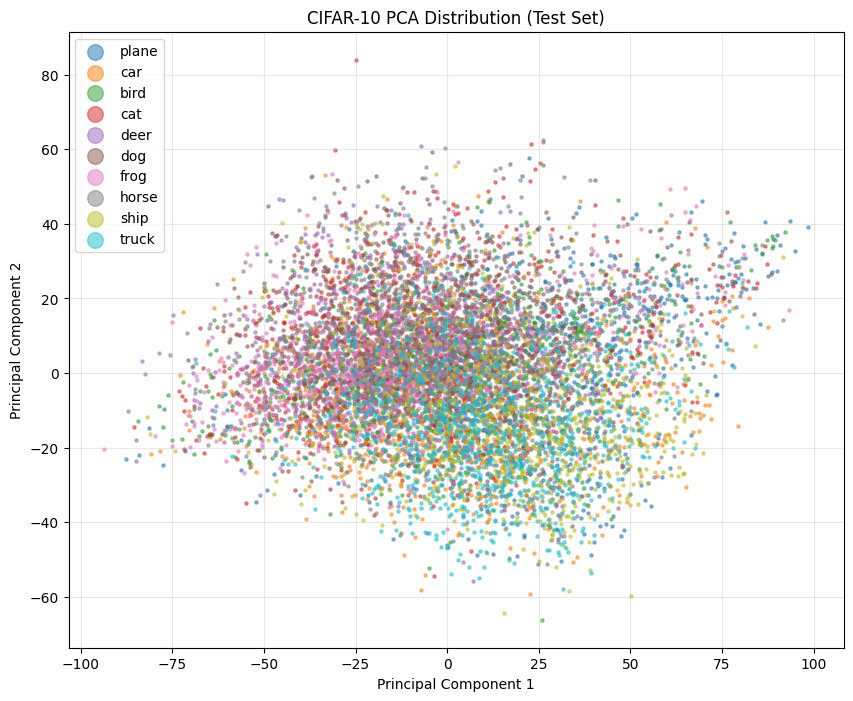


[Part A-(c)] Training Softmax Regression on 2D features...
Epoch [10/50], Train Loss: 2.8867, Test Loss: 2.9911
Epoch [20/50], Train Loss: 2.9037, Test Loss: 3.9218
Epoch [30/50], Train Loss: 2.9052, Test Loss: 3.3751
Epoch [40/50], Train Loss: 2.8957, Test Loss: 3.0651
Epoch [50/50], Train Loss: 2.9033, Test Loss: 2.7479


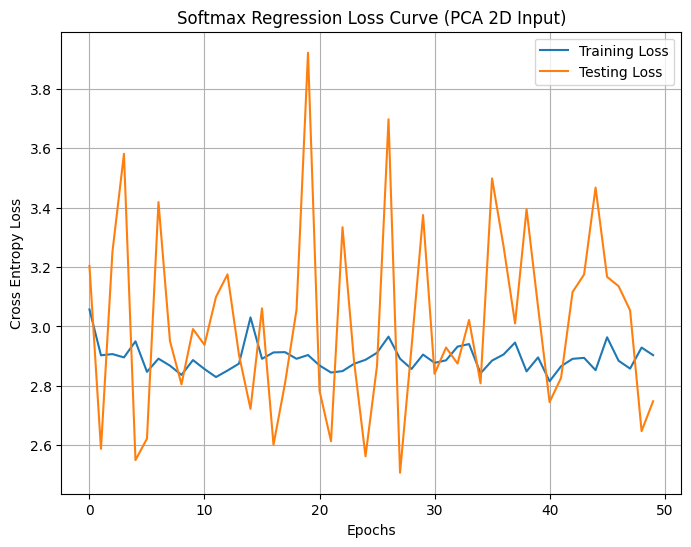


[Part A-(d)] Calculating Accuracy...
Training Accuracy: 15.55%
Testing Accuracy:  15.48%


In [ ]:

# Part A
# ==========================================
#Standardization
mean_vals = np.mean(X_train, axis=(0, 1, 2))
std_vals = np.std(X_train, axis=(0, 1, 2))
train_x_norm = (X_train - mean_vals) / (std_vals + 1e-7)
test_x_norm = (X_test - mean_vals) / (std_vals + 1e-7)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


X_train_flat = train_x_norm.reshape(len(X_train), -1).astype(np.float32)#flattening
X_test_flat = test_x_norm.reshape(len(X_test), -1).astype(np.float32)

# ==========================================
# (a) Train PCA Projection Matrix
# ==========================================
print("\n[Part A-(a)] Training PCA...")
# n (Original Dimension) = 3072
# d (Target Dimension) = 2
n = train_x_norm.shape[1]
d = 2
print(f"Determined dimensions -> n: {n}, d: {d}")

pca = PCA(n_components=d)#find principle component

#projection
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

print(f"PCA Done. Train Shape: {X_train_pca.shape}, Test Shape: {X_test_pca.shape}")

# ==========================================
# (b) Visualization (Scatter Plot)
# ==========================================
def plot_scatter(X, y, title):#scatter plot function
    plt.figure(figsize=(10, 8))
    for i in range(10):
        indices = np.where(y == i)
        plt.scatter(X[indices, 0], X[indices, 1], label=classes[i], alpha=0.5, s=5)

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best', markerscale=5)
    plt.grid(True, alpha=0.3)
    plt.show()

print("\n[Part A-(b)] Plotting Scatter plots...")
plot_scatter(X_train_pca, y_train, "CIFAR-10 PCA Distribution (Training Set)")#plot scatter plot for training set
plot_scatter(X_test_pca, y_test, "CIFAR-10 PCA Distribution (Test Set)")#plot scatter plot for test set

# ==========================================
# (c) Softmax Regression (Training)
# ==========================================
print("\n[Part A-(c)] Training Softmax Regression on 2D features...")

# 1. Prepare DataLoaders for PyTorch
tensor_x_train = torch.FloatTensor(X_train_pca)#convert to tensor
tensor_y_train = torch.LongTensor(y_train)#convert to tensor
tensor_x_test = torch.FloatTensor(X_test_pca)#convert to tensor
tensor_y_test = torch.LongTensor(y_test)#convert to tensor

train_dataset = TensorDataset(tensor_x_train, tensor_y_train)#create dataset
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)#create dataset

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)#create dataloader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)#create dataloader

# 2. Define Softmax Regression Model
# MLP without hidden layers: Input(2) -> Output(10)
class SoftmaxRegression(nn.Module):
    def __init__(self):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(2, 10) # 2 features -> 10 classes

    def forward(self, x):
        return self.linear(x) # CrossEntropyLoss includes Softmax internally

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#use GPU if available
model = SoftmaxRegression().to(device)#move model to GPU

criterion = nn.CrossEntropyLoss()#define loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)#define optimizer

# 3. Training Loop
num_epochs = 50
train_losses = []#store training loss
test_losses = []#store test loss

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:#train model
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)#calculate average training loss
    train_losses.append(avg_train_loss)

    # Calculate Test Loss
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():#test model
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot Loss Curves
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Softmax Regression Loss Curve (PCA 2D Input)')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid()
plt.show()

# ==========================================
# (d) Accuracy Calculation
# ==========================================
print("\n[Part A-(d)] Calculating Accuracy...")

def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total#calculate accuracy

train_acc = calculate_accuracy(train_loader, model)#calculate training accuracy
test_acc = calculate_accuracy(test_loader, model)#calculate test accuracy

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Testing Accuracy:  {test_acc:.2f}%")

Using Device: cuda
Starting Training...
Epoch 1/30 | Train Loss: 2.0678 | Test Loss: 1.7452
Epoch 2/30 | Train Loss: 1.6824 | Test Loss: 1.6234
Epoch 3/30 | Train Loss: 1.5870 | Test Loss: 1.5683
Epoch 4/30 | Train Loss: 1.5010 | Test Loss: 1.4438
Epoch 5/30 | Train Loss: 1.4039 | Test Loss: 1.4376
Epoch 6/30 | Train Loss: 1.3149 | Test Loss: 1.2495
Epoch 7/30 | Train Loss: 1.2539 | Test Loss: 1.2281
Epoch 8/30 | Train Loss: 1.1958 | Test Loss: 1.1408
Epoch 9/30 | Train Loss: 1.1436 | Test Loss: 1.0973
Epoch 10/30 | Train Loss: 1.0983 | Test Loss: 1.0552
Epoch 11/30 | Train Loss: 1.0561 | Test Loss: 1.0090
Epoch 12/30 | Train Loss: 1.0334 | Test Loss: 0.9889
Epoch 13/30 | Train Loss: 0.9951 | Test Loss: 0.9568
Epoch 14/30 | Train Loss: 0.9564 | Test Loss: 0.9364
Epoch 15/30 | Train Loss: 0.9349 | Test Loss: 0.9457
Epoch 16/30 | Train Loss: 0.9018 | Test Loss: 0.8832
Epoch 17/30 | Train Loss: 0.8762 | Test Loss: 0.8391
Epoch 18/30 | Train Loss: 0.8442 | Test Loss: 0.8070
Epoch 19/30 | T

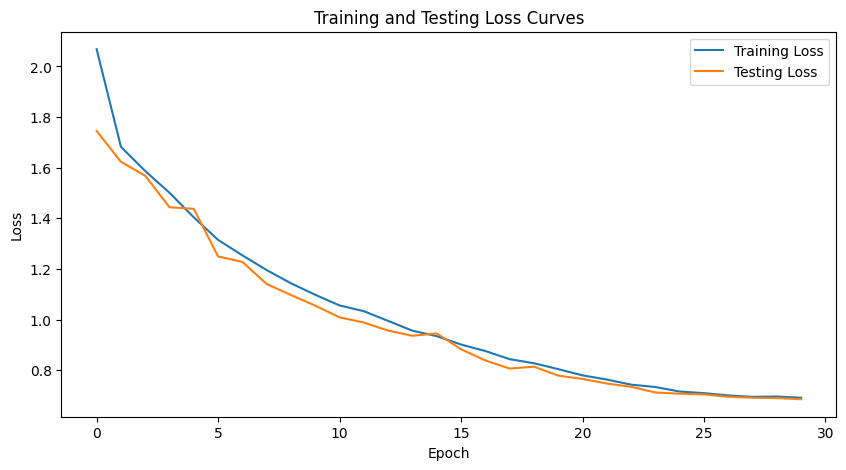

Extracting features...

[Part B(a)] Plotting Scatter plots...


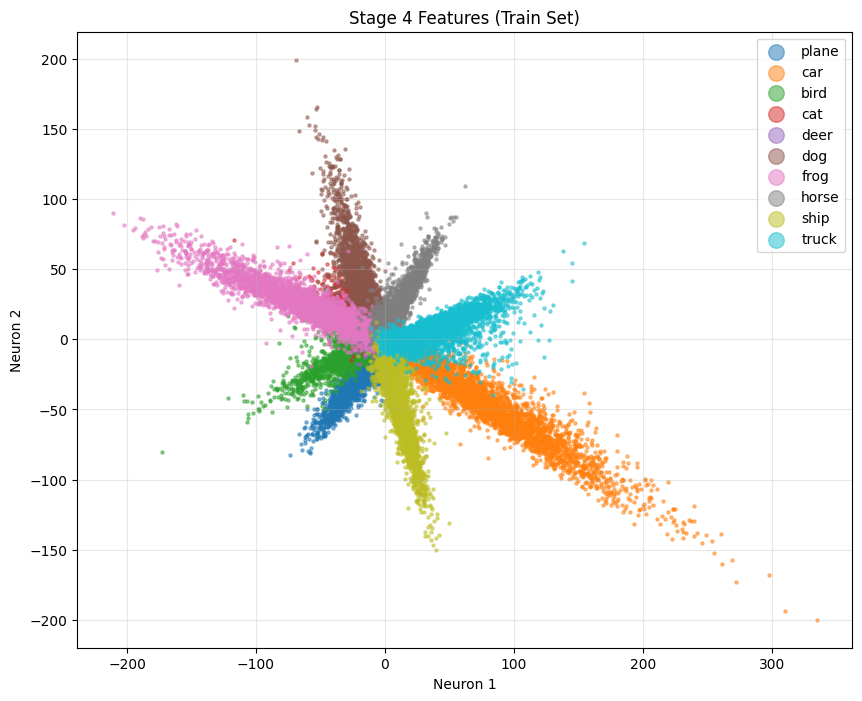

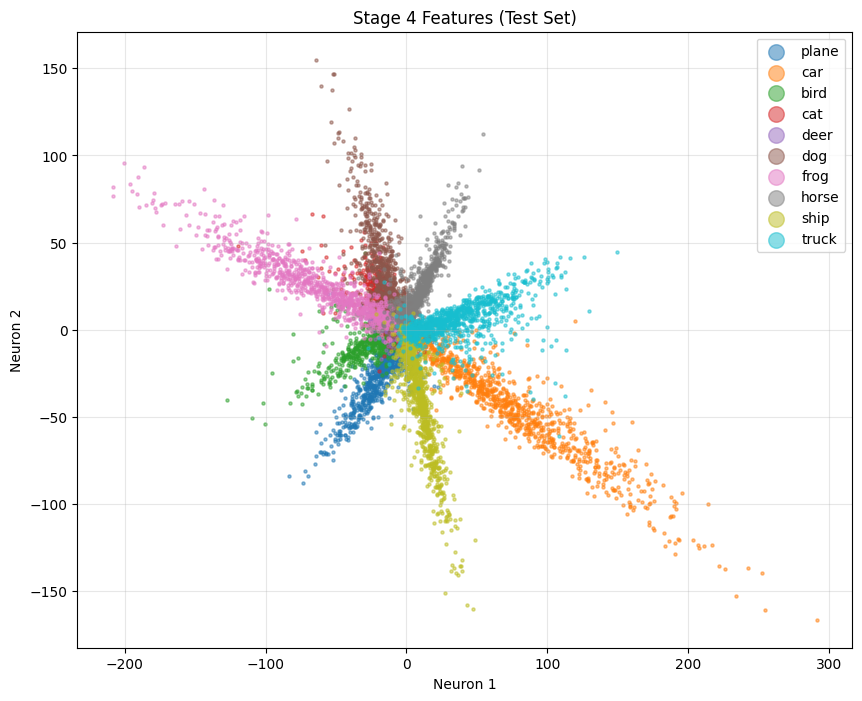

Epoch [10/50], Train Loss: 0.7487, Test Loss: 1.2790
Epoch [20/50], Train Loss: 0.7510, Test Loss: 1.0273
Epoch [30/50], Train Loss: 0.7527, Test Loss: 1.0591
Epoch [40/50], Train Loss: 0.7659, Test Loss: 1.0367
Epoch [50/50], Train Loss: 0.7631, Test Loss: 1.0040


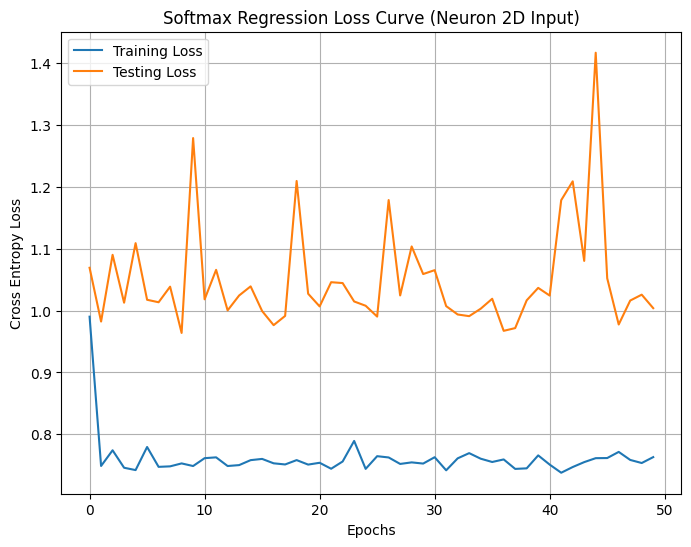


[Part B-(c)] Calculating Accuracy...
Training Accuracy: 74.98%
Testing Accuracy:  71.42%


In [ ]:

# Part B
# ==========================================
#]Configuration & Hyperparameters
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using Device: {DEVICE}")

# ==========================================
#Data Preprocessing (Normalization & Augmentation)
train_transform = transforms.Compose([
    transforms.ToPILImage(),#numpy to PIL
    transforms.RandomCrop(32, padding=4),#augmentation
    transforms.RandomHorizontalFlip(),#augmentation
    transforms.ToTensor() #PIL to tensor
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),#numpy to PIL
    transforms.ToTensor() #PIL to tensor
])

class NumpyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        target = self.targets[index]
        if self.transform:
            img = self.transform(img)
        return img, target

train_loader = DataLoader(NumpyDataset(X_train, y_train, train_transform), batch_size=64, shuffle=True)
test_loader = DataLoader(NumpyDataset(X_test, y_test, test_transform), batch_size=64, shuffle=False)
# ==========================================
#Model Definition (Based on the Table)
class DimReductionCNN(nn.Module):
    def __init__(self):
        super(DimReductionCNN, self).__init__()

        # Stage 1: (5,32)/1,2 x2 -> Conv 5x5, 32ch, pad 2
        self.stage1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),#input 3 channels, output 32 channels, kernel size 5x5, stride 1, padding 2
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),#input 32 channels, output 32 channels, kernel size 5x5, stride 1, padding 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16
        )

        # Stage 2: (5,64)/1,2 x2
        self.stage2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),#input 32 channels, output 64 channels, kernel size 5x5, stride 1, padding 2
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),#input 64 channels, output 64 channels, kernel size 5x5, stride 1, padding 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 16 -> 8
        )

        # Stage 3: (5,128)/1,2 x2
        self.stage3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),#input 64 channels, output 128 channels, kernel size 5x5, stride 1, padding 2
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),#input 128 channels, output 128 channels, kernel size 5x5, stride 1, padding 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 8 -> 4
        )

        # Flatten size: 128 channels * 4 * 4 = 2048

        # Stage 4: FC, 2, linear (Dimension Reduction Layer)
        self.stage4 = nn.Linear(128 * 4 * 4, 2)#input 2048, output 2

        # Stage 5: Output, 10
        # Note: Softmax is included in CrossEntropyLoss internally during training
        self.stage5 = nn.Linear(2, 10)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)

        x = torch.flatten(x, 1) # Flatten

        features = self.stage4(x) # Extract Stage 4 Features (2D)
        out = self.stage5(features)

        return features, out

model = DimReductionCNN().to(DEVICE)

# ==========================================
# Training Setup (Optimizer, Scheduler)
criterion = nn.CrossEntropyLoss()#CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)#Adam
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)#CosineAnnealingLR

# ==========================================
#Training Loop
train_losses = []
test_losses = []

def train(epoch):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:#train_loader
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    scheduler.step() # Update LR
    return avg_loss

def test(epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in train_loader:#train_loader
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            _, outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    test_losses.append(avg_loss)
    return avg_loss

print("Starting Training...")
for epoch in range(EPOCHS):
    
    train_loss = train(epoch)
    test_loss = test(epoch)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ==========================================
# Part (a): Feature Extraction & Visualization

def extract_features(loader):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(DEVICE)
            feats, _ = model(inputs)
            features_list.append(feats.cpu().numpy())
            labels_list.append(targets.numpy())
    return np.concatenate(features_list), np.concatenate(labels_list)

# Extract Features
print("Extracting features...")
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

# Plotting Function
def plot_scatter(X, y, title):
    plt.figure(figsize=(10, 8))
    for i in range(10):
        indices = np.where(y == i)
        plt.scatter(X[indices, 0], X[indices, 1], label=classes[i], alpha=0.5, s=5)

    plt.title(title)
    plt.xlabel('Neuron 1')
    plt.ylabel('Neuron 2')
    plt.legend(loc='best', markerscale=5)
    plt.grid(True, alpha=0.3)
    plt.show()

print("\n[Part B(a)] Plotting Scatter plots...")

plot_scatter(train_features, train_labels, "Stage 4 Features (Train Set)")#plot_scatter train_features
plot_scatter(test_features, test_labels, "Stage 4 Features (Test Set)")#plot_scatter test_features

# ==========================================
# Part (b) & (c): Softmax Regression on 2D Features
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SoftmaxRegression().to(device)

tensor_x_train = torch.FloatTensor(train_features)#train_features
tensor_y_train = torch.LongTensor(train_labels)#train_labels
tensor_x_test = torch.FloatTensor(test_features)#test_features
tensor_y_test = torch.LongTensor(test_labels)#test_labels

train_dataset = TensorDataset(tensor_x_train, tensor_y_train)#train_dataset
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)#test_dataset

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)#train_loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)#test_loader

criterion = nn.CrossEntropyLoss()#CrossEntropyLoss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)#SGD

num_epochs = 50#epochs
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Calculate Test Loss
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot Loss Curves
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Softmax Regression Loss Curve (Neuron 2D Input)')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid()
plt.show()

# ==========================================
# (d) Accuracy Calculation
print("\n[Part B-(c)] Calculating Accuracy...")

train_acc = calculate_accuracy(train_loader, model)
test_acc = calculate_accuracy(test_loader, model)

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Testing Accuracy:  {test_acc:.2f}%")